<a href="https://colab.research.google.com/github/helloerikaaa/speech-recognition/blob/master/speech_rec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
!unzip train.zip
!unzip test.zip

Archive:  train.zip
replace train/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: train/.DS_Store         
  inflating: train/audio/.DS_Store   
  inflating: train/audio/cargar_ruta/cargar_ruta_1594849548434_1234.wav  
  inflating: train/audio/cargar_ruta/cargar_ruta_1594849773539_1234.wav  
  inflating: train/audio/cargar_ruta/cargar_ruta_1594848968505_1234.wav  
  inflating: train/audio/cargar_ruta/cargar_ruta_1594849199147_1234.wav  
  inflating: train/audio/cargar_ruta/cargar_ruta_1594849888989_1234.wav  
  inflating: train/audio/cargar_ruta/cargar_ruta_1594849097396_1234.wav  
  inflating: train/audio/cargar_ruta/cargar_ruta_1594849490163_1234.wav  
  inflating: train/audio/cargar_ruta/cargar_ruta_1594849342747_1234.wav  
  inflating: train/audio/cargar_ruta/cargar_ruta_1594849280880_1234.wav  
  inflating: train/audio/cargar_ruta/cargar_ruta_1594849678257_1234.wav  
  inflating: train/audio/cargar_ruta/cargar_ruta_1594849398763_1234.wav  
  inflating: train/audio/

In [87]:
!pip install sounddevice
!pip install soundfile
!pip install tqdm
!apt-get install libportaudio2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libportaudio2 is already the newest version (19.6.0-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [88]:
import os
import librosa
import warnings
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import Session
from tensorflow.compat.v1.keras.layers import Bidirectional, BatchNormalization, CuDNNGRU, TimeDistributed
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from tensorflow.compat.v1.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.compat.v1.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.compat.v1.keras import backend as K
from keras.utils import np_utils
from scipy.io import wavfile
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import random

import sounddevice as sd
import soundfile as sf
from tqdm import tqdm

In [89]:
config = ConfigProto()
config.gpu_options.allow_growth = True
sess = Session(config=config)

warnings.filterwarnings("ignore")

In [90]:
labels = [
    'abonar', 'adios_pepe', 'ayuda', 'cargar_ruta', 'como_me_llamo', 'hola_pepe', 'que_hora_es', 'quien_eres', 'quien_te_hizo'
]

In [91]:
train_audio_path = './train/audio/'

all_wave = []
all_label = []
for label in tqdm(labels):
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        samples = librosa.util.fix_length(samples, 8000, mode='edge')

        if(len(samples)== 8000) :
            all_wave.append(samples)
            all_label.append(label)

100%|██████████| 9/9 [00:46<00:00,  5.16s/it]


In [92]:
label_enconder = LabelEncoder()
y = label_enconder.fit_transform(all_label)
classes = list(label_enconder.classes_)
y = np_utils.to_categorical(y, num_classes=len(labels))

all_wave = np.array(all_wave).reshape(-1,8000,1)

x_train, x_valid, y_train, y_valid = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)


K.clear_session()

In [93]:
inputs = Input(shape=(8000,1))
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)(inputs)

#First Conv1D layer
x = Conv1D(8,13, padding='valid', activation='relu', strides=1)(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.3)(x)

#Second Conv1D layer
x = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.3)(x)

#Third Conv1D layer
x = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.3)(x)

x = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)(x)

x = Bidirectional(CuDNNGRU(128, return_sequences=True), merge_mode='sum')(x)
x = Bidirectional(CuDNNGRU(128, return_sequences=True), merge_mode='sum')(x)
x = Bidirectional(CuDNNGRU(128, return_sequences=False), merge_mode='sum')(x)

x = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)(x)

#Flatten layer
# x = Flatten()(x)

#Dense Layer 1
x = Dense(256, activation='relu')(x)
outputs = Dense(len(labels), activation="softmax")(x)

In [94]:
model = Model(inputs, outputs)
model.summary()

model.compile(loss='categorical_crossentropy',optimizer='nadam',metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', mode='min', 
                           verbose=1, patience=10, min_delta=0.0001)

checkpoint = ModelCheckpoint('model.hdf5', monitor='val_acc', 
                             verbose=1, save_best_only=True, mode='max')

hist = model.fit(
    x=x_train, 
    y=y_train,
    epochs=100, 
    callbacks=[early_stop, checkpoint], 
    batch_size=32, 
    validation_data=(x_valid,y_valid)
)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8000, 1)           4         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0     

3/3 [==============================] - 1s 319ms/step - loss: 2.5185 - accuracy: 0.0645 - val_loss: 2.1970 - val_accuracy: 0.1250
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 2.2337 - accuracy: 0.1720WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 0s 76ms/step - loss: 2.2337 - accuracy: 0.1720 - val_loss: 2.1969 - val_accuracy: 0.0417
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 2.2294 - accuracy: 0.1828WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 0s 163ms/step - loss: 2.2294 - accuracy: 0.1828 - val_loss: 2.1962 - val_accuracy: 0.1250
Epoch 4/100
3/3 [==============================] - ETA: 0s - loss: 2.0689 - accuracy: 0.2151WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 0s 76ms/step - loss: 2.0689 - accuracy: 0.2151 - val_loss: 2.1965 - val_accuracy: 0.1250
Epoch 5/100
3/3 [==============================] - ETA: 0s - loss: 2.1056 - accuracy: 0.2473WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 0s 78ms/step - loss: 2.1056 - accuracy: 0.2473 - val_loss: 2.1978 - val_accuracy: 0.0833
Epoch 6/100
3/3 [==============================] - ETA: 0s - loss: 2.0164 - accuracy: 0.2366WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 0s 75ms/step - loss: 2.0164 - accuracy: 0.2366 - val_loss: 2.1977 - val_accuracy: 0.0417
Epoch 7/100
3/3 [==============================] - ETA: 0s - loss: 2.0899 - accuracy: 0.2366WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 0s 74ms/step - loss: 2.0899 - accuracy: 0.2366 - val_loss: 2.1991 - val_accuracy: 0.0833
Epoch 8/100
3/3 [==============================] - ETA: 0s - loss: 2.0731 - accuracy: 0.2258WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 0s 76ms/step - loss: 2.0731 - accuracy: 0.2258 - val_loss: 2.2023 - val_accuracy: 0.0833
Epoch 9/100
3/3 [==============================] - ETA: 0s - loss: 2.0419 - accuracy: 0.2903WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 0s 71ms/step - loss: 2.0419 - accuracy: 0.2903 - val_loss: 2.2060 - val_accuracy: 0.0833
Epoch 10/100
3/3 [==============================] - ETA: 0s - loss: 1.9942 - accuracy: 0.2366WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 0s 72ms/step - loss: 1.9942 - accuracy: 0.2366 - val_loss: 2.2214 - val_accuracy: 0.0833
Epoch 11/100
3/3 [==============================] - ETA: 0s - loss: 2.0425 - accuracy: 0.3011WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 0s 74ms/step - loss: 2.0425 - accuracy: 0.3011 - val_loss: 2.2194 - val_accuracy: 0.0833
Epoch 12/100
3/3 [==============================] - ETA: 0s - loss: 1.9277 - accuracy: 0.2903WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 0s 83ms/step - loss: 1.9277 - accuracy: 0.2903 - val_loss: 2.2357 - val_accuracy: 0.0833
Epoch 13/100
3/3 [==============================] - ETA: 0s - loss: 1.9377 - accuracy: 0.2151WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 0s 77ms/step - loss: 1.9377 - accuracy: 0.2151 - val_loss: 2.2406 - val_accuracy: 0.0833
Epoch 00013: early stopping


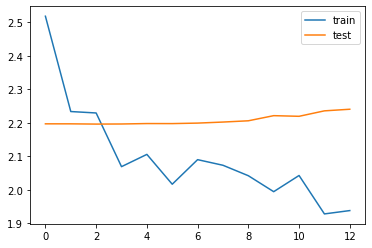

In [95]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='test')
plt.legend()
plt.show()

In [96]:
model.compile(loss='categorical_crossentropy',optimizer='nadam',metrics=['accuracy'])

In [97]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
checkpoint = ModelCheckpoint('model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [98]:
hist = model.fit(
    x=x_train, 
    y=y_train,
    epochs=100, 
    callbacks=[early_stop, checkpoint], 
    batch_size=32, 
    validation_data=(x_valid,y_valid)
)

Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 1.9340 - accuracy: 0.2366WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 1s 302ms/step - loss: 1.9340 - accuracy: 0.2366 - val_loss: 2.2425 - val_accuracy: 0.0833
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 1.9315 - accuracy: 0.2796WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 0s 81ms/step - loss: 1.9315 - accuracy: 0.2796 - val_loss: 2.2770 - val_accuracy: 0.0833
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 1.8089 - accuracy: 0.3118WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 0s 82ms/step - loss: 1.8089 - accuracy: 0.3118 - val_loss: 2.2304 - val_accuracy: 0.0833
Epoch 4/100
3/3 [==============================] - ETA: 0s - loss: 1.8302 - accuracy: 0.3548WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 0s 74ms/step - loss: 1.8302 - accuracy: 0.3548 - val_loss: 2.2888 - val_accuracy: 0.0833
Epoch 5/100
3/3 [==============================] - ETA: 0s - loss: 1.8640 - accuracy: 0.2688WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 0s 73ms/step - loss: 1.8640 - accuracy: 0.2688 - val_loss: 2.2775 - val_accuracy: 0.0833
Epoch 6/100
3/3 [==============================] - ETA: 0s - loss: 1.7821 - accuracy: 0.3763WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 0s 71ms/step - loss: 1.7821 - accuracy: 0.3763 - val_loss: 2.3068 - val_accuracy: 0.0833
Epoch 7/100
3/3 [==============================] - ETA: 0s - loss: 1.7857 - accuracy: 0.3763WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 0s 73ms/step - loss: 1.7857 - accuracy: 0.3763 - val_loss: 2.2577 - val_accuracy: 0.0833
Epoch 8/100
3/3 [==============================] - ETA: 0s - loss: 1.5919 - accuracy: 0.3656WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 0s 71ms/step - loss: 1.5919 - accuracy: 0.3656 - val_loss: 2.3048 - val_accuracy: 0.0833
Epoch 9/100
3/3 [==============================] - ETA: 0s - loss: 1.6921 - accuracy: 0.3441WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 0s 70ms/step - loss: 1.6921 - accuracy: 0.3441 - val_loss: 2.2948 - val_accuracy: 0.0833
Epoch 10/100
3/3 [==============================] - ETA: 0s - loss: 1.6650 - accuracy: 0.3763WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 0s 71ms/step - loss: 1.6650 - accuracy: 0.3763 - val_loss: 2.2818 - val_accuracy: 0.0833
Epoch 11/100
3/3 [==============================] - ETA: 0s - loss: 1.6471 - accuracy: 0.3871WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 0s 71ms/step - loss: 1.6471 - accuracy: 0.3871 - val_loss: 2.2925 - val_accuracy: 0.1667
Epoch 12/100
3/3 [==============================] - ETA: 0s - loss: 1.4881 - accuracy: 0.4624WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 0s 72ms/step - loss: 1.4881 - accuracy: 0.4624 - val_loss: 2.3542 - val_accuracy: 0.0833
Epoch 13/100
3/3 [==============================] - ETA: 0s - loss: 1.6450 - accuracy: 0.3871WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 0s 71ms/step - loss: 1.6450 - accuracy: 0.3871 - val_loss: 2.4372 - val_accuracy: 0.0833
Epoch 00013: early stopping


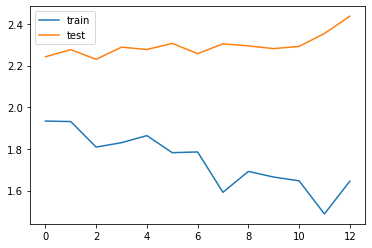

In [99]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='test')
plt.legend()
plt.show()

In [106]:
model.save('model.hdf5')
model = load_model('model.hdf5')

In [101]:
def s2t_predict(audio, shape_num=8000):
    prob=model.predict(audio.reshape(1,shape_num,1))
    index=np.argmax(prob[0])
    return classes[index]

In [102]:
index=random.randint(0,len(x_valid)-1)
samples=x_valid[index].ravel()
print("Audio:",classes[np.argmax(y_valid[index])])
ipd.Audio(samples, rate=8000)

Audio: quien_te_hizo


In [103]:
samples.shape

(8000,)

In [104]:
print("Text:",s2t_predict(samples))

Text: cargar_ruta
